In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

import branca
import branca.colormap as cm



from wetterdienst import Wetterdienst
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

from datetime import datetime, timedelta


def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=[DwdObservationDataset.TEMPERATURE_AIR],
                                resolution=DwdObservationResolution.MINUTE_10,
                                start_date=start_date,
                                end_date=end_date,
                                ).filter_by_name(name=name)

    df_res = request.values.all().df.dropna()

    df_Temp=df_res[df_res.parameter=="temperature_air_mean_200"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_Temp.rename(columns={'value':'T'}, inplace=True)
    df_dew=df_res[df_res.parameter=="temperature_dew_point_mean_200"].drop(['station_id', 'dataset', 'parameter', 'quality'], axis=1)
    
    df_dew.rename(columns={'value':'Td'}, inplace=True)
    
    df_Temp.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    
    df_dew.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    df_out=df_Temp.merge(df_dew, how='left', left_index=True, right_index=True)
    df_out["time"]=pd.to_datetime(df_Temp.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    #df_out["SEC"]=pd.to_timedelta(df_Temp.date).dt.total_seconds()
    df_out.set_index(df_out["time"], inplace=True)
    #df_out.drop(["date"], axis=1)
    #df_out.set_index("time", inplace=True)
    df_out=df_out.drop(["date_x", "date_y"], axis=1)
    df_out["T"]=df_out["T"]-273.15
    df_out["Td"]=df_out["Td"]-273.15
    return df_out



In [23]:
#fn = "./dcsv/2022-05-06T18_08_35.000Z.csv"
fn="./dcsv/2022-05-18T16_55_32.000Z.csv"
#fn="./dcsv/Leipzig - Leipzig 2022-06-02T17_47_56+0200_Jakob.csv"
station="Leipzig-Holzhausen"
#station="Leipzig/Halle"

ds = pd.read_csv(fn)

#ds=ds[50:-50]
#print(ds)

ds.time=pd.to_datetime(ds.time, format="%Y-%m-%dT%H:%M:%S.%fZ")
#print(ds)

ds.set_index(pd.DatetimeIndex(ds["time"]), inplace=True)
ds=ds[ds["Speed[km/h]"]>10]
print(ds)


                                   time        lon        lat  Temp[°C]  \
time                                                                      
2022-05-18 16:55:24 2022-05-18 16:55:24  12.397615  51.309436      26.5   
2022-05-18 16:55:29 2022-05-18 16:55:29  12.398039  51.309431      26.3   
2022-05-18 16:55:32 2022-05-18 16:55:32  12.398267  51.309414      26.2   
2022-05-18 16:55:35 2022-05-18 16:55:35  12.398495  51.309393      26.2   
2022-05-18 16:55:38 2022-05-18 16:55:38  12.398761  51.309351      26.1   
...                                 ...        ...        ...       ...   
2022-05-18 19:17:51 2022-05-18 19:17:51  12.396563  51.309225      21.6   
2022-05-18 19:17:54 2022-05-18 19:17:54  12.396534  51.309376      21.6   
2022-05-18 19:17:57 2022-05-18 19:17:57  12.396515  51.309508      21.6   
2022-05-18 19:18:00 2022-05-18 19:18:00  12.396538  51.309582      21.6   
2022-05-18 19:18:03 2022-05-18 19:18:03  12.396622  51.309658      21.6   

                     DP[

In [8]:
map_OSM = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')
map_OSM

In [9]:


lat = ds.lat
lon = ds.lon
t = ds['Temp[°C]']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[0,5,8,10,12,15,20,25],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM

time
2022-05-18 16:58:11    24.7
2022-05-18 16:58:14    24.6
2022-05-18 16:58:17    24.6
2022-05-18 16:58:20    24.6
2022-05-18 16:58:23    24.6
                       ... 
2022-05-18 19:15:48    21.6
2022-05-18 19:15:51    21.6
2022-05-18 19:15:54    21.7
2022-05-18 19:15:57    21.7
2022-05-18 19:16:00    21.8
Name: Temp[°C], Length: 1318, dtype: float64


In [12]:
start_date=datetime.strftime(min(ds.time), format="%Y-%m-%d")
end_date=datetime.strftime(max(ds.time)+np.timedelta64(1, 'D'), format="%Y-%m-%d")

DWD=station_temp(station, start_date, end_date)



In [13]:
#df_compared=ds.merge(Holzhausen, how="outer", sort=True, left_index=True, right_index=True)
df_compared=ds.merge(DWD, how="outer", sort=True, left_index=True, right_index=True)


df_compared=df_compared.drop(["time_x", "time_y"], axis=1)

df_compared["T"]=df_compared["T"].interpolate(method="time", inplace=False, axis=0)
df_compared["Td"]=df_compared["Td"].interpolate(method="time", inplace=False, axis=0)
df_compared["T_diff"]=df_compared["Temp[°C]"]-df_compared["T"]


Text(0.5, 0.98, 'Zeitreihe Messfahrt')

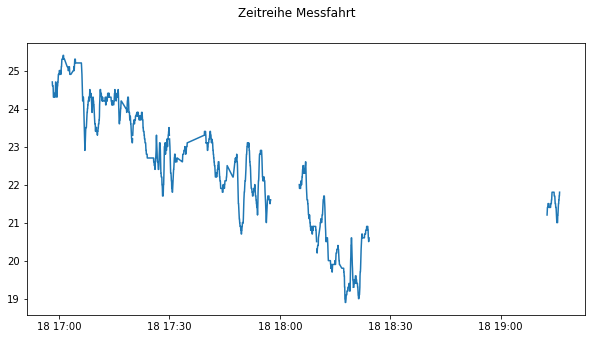

In [14]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["Temp[°C]"], label="T Track")
fig.suptitle("Zeitreihe Messfahrt")

Text(0.5, 0.98, 'T Leipzig-Holzhausen')

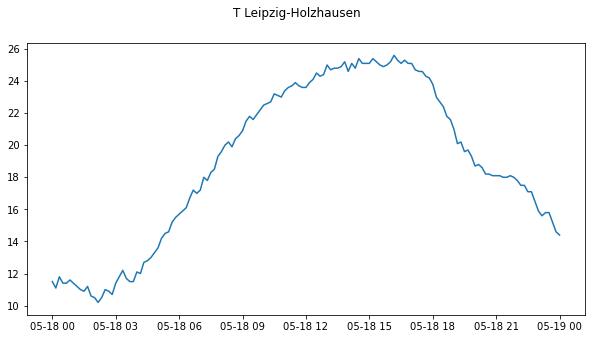

In [15]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
fig.suptitle("T "+station)

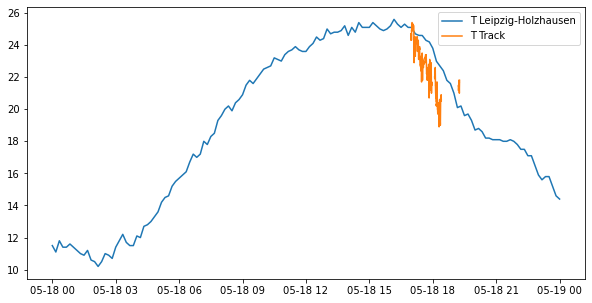

In [16]:

fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared["Temp[°C]"], label="T Track")
ax.legend()

(19130.707071759258, 19130.80277777778)

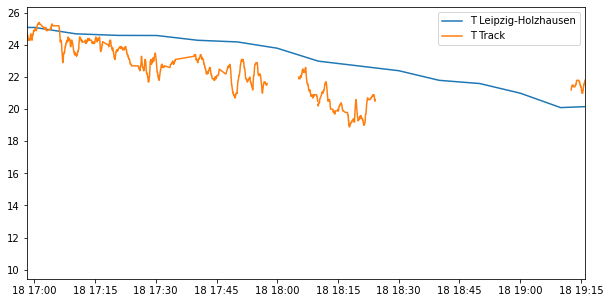

In [17]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared["Temp[°C]"], label="T Track")
ax.legend()
ax.set_xlim([min(ds.time),max(ds.time) ])

Text(0.5, 0.98, 'Temperaturdifferenz Messfahrt - Leipzig-Holzhausen')

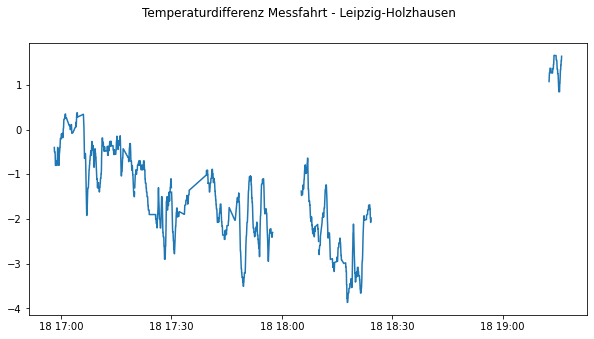

In [18]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared.T_diff)
fig.suptitle("Temperaturdifferenz Messfahrt - "+station)

In [19]:
map_OSM2 = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')


lat = ds.lat
lon = ds.lon
t = df_compared['T_diff']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[-1,-0.5, 0, 0.5, 1,2,5, 7],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM2.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM2

time
2022-05-18 00:00:00   NaN
2022-05-18 00:10:00   NaN
2022-05-18 00:20:00   NaN
2022-05-18 00:30:00   NaN
2022-05-18 00:40:00   NaN
                       ..
2022-05-18 23:20:00   NaN
2022-05-18 23:30:00   NaN
2022-05-18 23:40:00   NaN
2022-05-18 23:50:00   NaN
2022-05-19 00:00:00   NaN
Name: T_diff, Length: 1463, dtype: float64
